# 4-Beam Cross-Talk Demixing

Problem: When one beam scans, other detectors pick up leaked signal (cross-talk). Each detector sees a mix of its own beam plus bleed from the other 3.

Solution: Subtract the estimated cross-talk from each detector's signal using calibration data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mbo_utilities as mbo
from pathlib import Path

In [2]:
# configuration
beam_labels = ["NW", "SW", "SE", "NE"]
fs_to_label = {"FS1": "NW", "FS2": "SW", "FS3": "SE", "FS4": "NE"}
label_to_fs = {v: k for k, v in fs_to_label.items()}

base_recording = r"D:\cj\2025-11-21\raw"
base_calib = r"D:\cj\2025-11-21\raw\calibration"  # adjust path as needed

cal_mode = "mip"  # "mean" or "mip"

## Load Data

- VD0/VD1: two vDAQ channels, each with 2 planes
- Reorder planes to match beam labels (NW, SW, SE, NE)

In [11]:
def load_mean_recording(base_path):
    """load recordings and compute temporal mean per plane."""
    vd0 = mbo.imread(os.path.join(base_path, "vdaq0"), mode="r").astype(np.float32)
    vd1 = mbo.imread(os.path.join(base_path, "vdaq1"), mode="r").astype(np.float32)

    vd0_mean = vd0.mean(axis=0)
    vd1_mean = vd1.mean(axis=0)

    raw = [vd0_mean[0], vd0_mean[1], vd1_mean[0], vd1_mean[1]]
    perm = [3, 2, 1, 0]
    return dict(zip(beam_labels, [raw[k] for k in perm]))


def load_full_recording(base_path):
    """load full timeseries, returns (4, T, Y, X)."""
    vd0 = mbo.imread(os.path.join(base_path, "vdaq0")).astype(np.float32)
    vd1 = mbo.imread(os.path.join(base_path, "vdaq1")).astype(np.float32)

    raw = [vd0[:, 0], vd0[:, 1], vd1[:, 0], vd1[:, 1]]
    perm = [3, 2, 1, 0]
    return np.stack([raw[k] for k in perm], axis=0)


def load_calibration(base_path, scan_label, mode="mip"):
    """load calibration scan for a single beam."""
    fs_label = label_to_fs[scan_label]

    z0 = mbo.imread(os.path.join(base_path, f"{fs_label}_VD0")).astype(np.float32)
    z1 = mbo.imread(os.path.join(base_path, f"{fs_label}_VD1")).astype(np.float32)

    if mode == "mean":
        vd0, vd1 = z0.mean(axis=0), z1.mean(axis=0)
    else:  # mip
        vd0, vd1 = z0.max(axis=0), z1.max(axis=0)

    raw = [vd0[0], vd0[1], vd1[0], vd1[1]]
    # perm = [3, 2, 1, 0]  # or [2, 3, 1, 0]?
    perm = [2, 3, 1, 0]
    return [raw[k] for k in perm]

perm = [3, 2, 1, 0]  # maps vd0[0], vd0[1], vd1[0], vd1[1] → NW, SW, SE, NE

This means:
NW = vd1[1] (index 3)
SW = vd1[0] (index 2)
SE = vd0[1] (index 1)
NE = vd0[0] (index 0)

In [31]:
vd0_f = mbo.imread(os.path.join(base_recording, "vdaq0")).astype(np.float32)
vd1_f = mbo.imread(os.path.join(base_recording, "vdaq1")).astype(np.float32)
vd0 = mbo.imread(os.path.join(base_recording, "vdaq0"))
vd1 = mbo.imread(os.path.join(base_recording, "vdaq1"))

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# print(vd0.metadata["use_fft"], vd0.metadata["fix_phase"])
# print(vd0_f.metadata["use_fft"], vd0_f.metadata["fix_phase"])
# print(vd0.metadata["dtype"], vd1.metadata["dtype"])
print(vd0.dtype)

int16


In [5]:
# load recording
R = load_full_recording(base_recording)
print(f"Recording shape [det, T, Y, X]: {R.shape}")

mean_rec = load_mean_recording(base_recording)

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Recording shape [det, T, Y, X]: (4, 970, 772, 735)


Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

Computing mean:   0%|          | 0/10 [00:00<?, ?it/s]

Computing mean:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
print(R.shape, mean_rec.keys())

(4, 970, 772, 735) dict_keys(['NW', 'SW', 'SE', 'NE'])


In [12]:
# load calibration and build mixing matrix
cal_all = {label: load_calibration(base_calib, label, cal_mode) for label in beam_labels}

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

Computing max:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
ny, nx = mean_rec["NW"].shape
M_init = np.zeros((4, 4, ny, nx), dtype=np.float32)

for i, scan in enumerate(beam_labels):
    for j, det in enumerate(beam_labels):
        M_init[i, j] = cal_all[scan][j]

print(f"Mixing matrix shape [src, det, Y, X]: {M_init.shape}")

Mixing matrix shape [src, det, Y, X]: (4, 4, 772, 735)


## Mixing Matrix

```
M_init[src, det, y, x]
```
- Row = source beam being scanned alone during calibration
- Column = detector response
- Diagonal = direct signal
- Off-diagonal = cross-talk

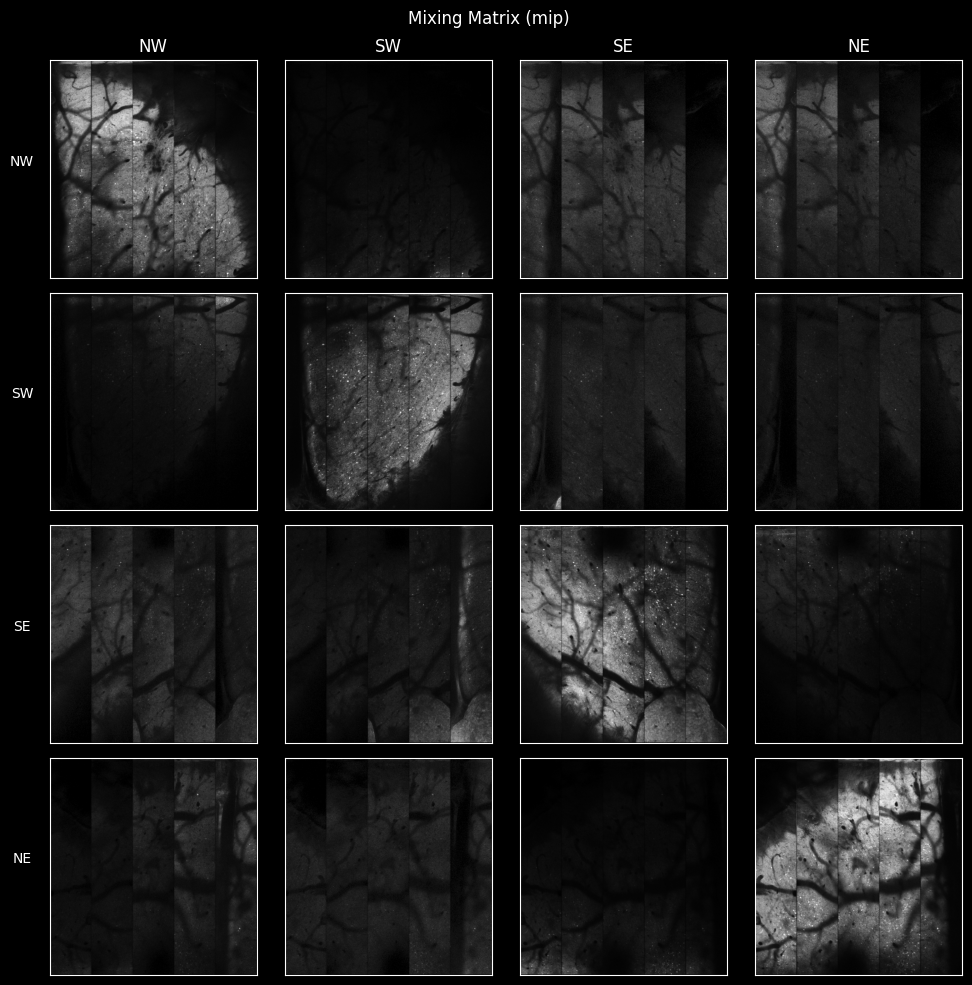

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle(f"Mixing Matrix ({cal_mode})")

for i, src in enumerate(beam_labels):
    for j, det in enumerate(beam_labels):
        ax = axes[i, j]
        ax.imshow(M_init[i, j], cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(det)
        if j == 0:
            ax.set_ylabel(src, rotation=0, labelpad=20)

plt.tight_layout()
plt.show()

## Demixing Algorithm

For each detector, subtract estimated cross-talk from other sources:

```
S[det] = R[det] - sum(conf * w[src,det] * R[src])  for src != det
```

**Components:**

| Term | Formula | Purpose |
|------|---------|--------|
| `noise_floor` | `percentile(diagonal, 20)` | background estimate |
| `conf[det]` | `diag / (diag + noise_floor)` | pixel-wise confidence (0-1) |
| `w[src,det]` | `M[src,det] / M[det,det]` | cross-talk ratio |

In [15]:
def demix_recording(R, M_init, noise_percentile=20):
    """confidence-weighted cross-talk subtraction."""
    D, T, Y, X = R.shape

    # noise floor from diagonal
    noise_floor = np.array([
        np.percentile(M_init[i, i], noise_percentile)
        for i in range(D)
    ], dtype=np.float32)

    # confidence weights
    conf = np.zeros((D, Y, X), dtype=np.float32)
    for det in range(D):
        diag = M_init[det, det]
        conf[det] = diag / (diag + noise_floor[det])

    # cross-talk weights
    w = np.zeros_like(M_init)
    for src in range(D):
        for det in range(D):
            if src != det:
                w[src, det] = M_init[src, det] / (M_init[det, det] + 1e-12)

    # subtract cross-talk
    S = np.zeros_like(R)
    for det in range(D):
        S[det] = R[det].copy()
        for src in range(D):
            if src != det:
                S[det] -= conf[det][None, :, :] * w[src, det][None, :, :] * R[src]
        S[det] = np.clip(S[det], 0, None)

    return S

In [16]:
S_est = demix_recording(R, M_init)
print(f"Demixed shape: {S_est.shape}")

Demixed shape: (4, 970, 772, 735)


## Results: Removed Cross-Talk

RGB overlay: **green = kept signal**, **magenta = removed cross-talk**

If magenta shows cell-like structures, those were ghost cells from other beams.

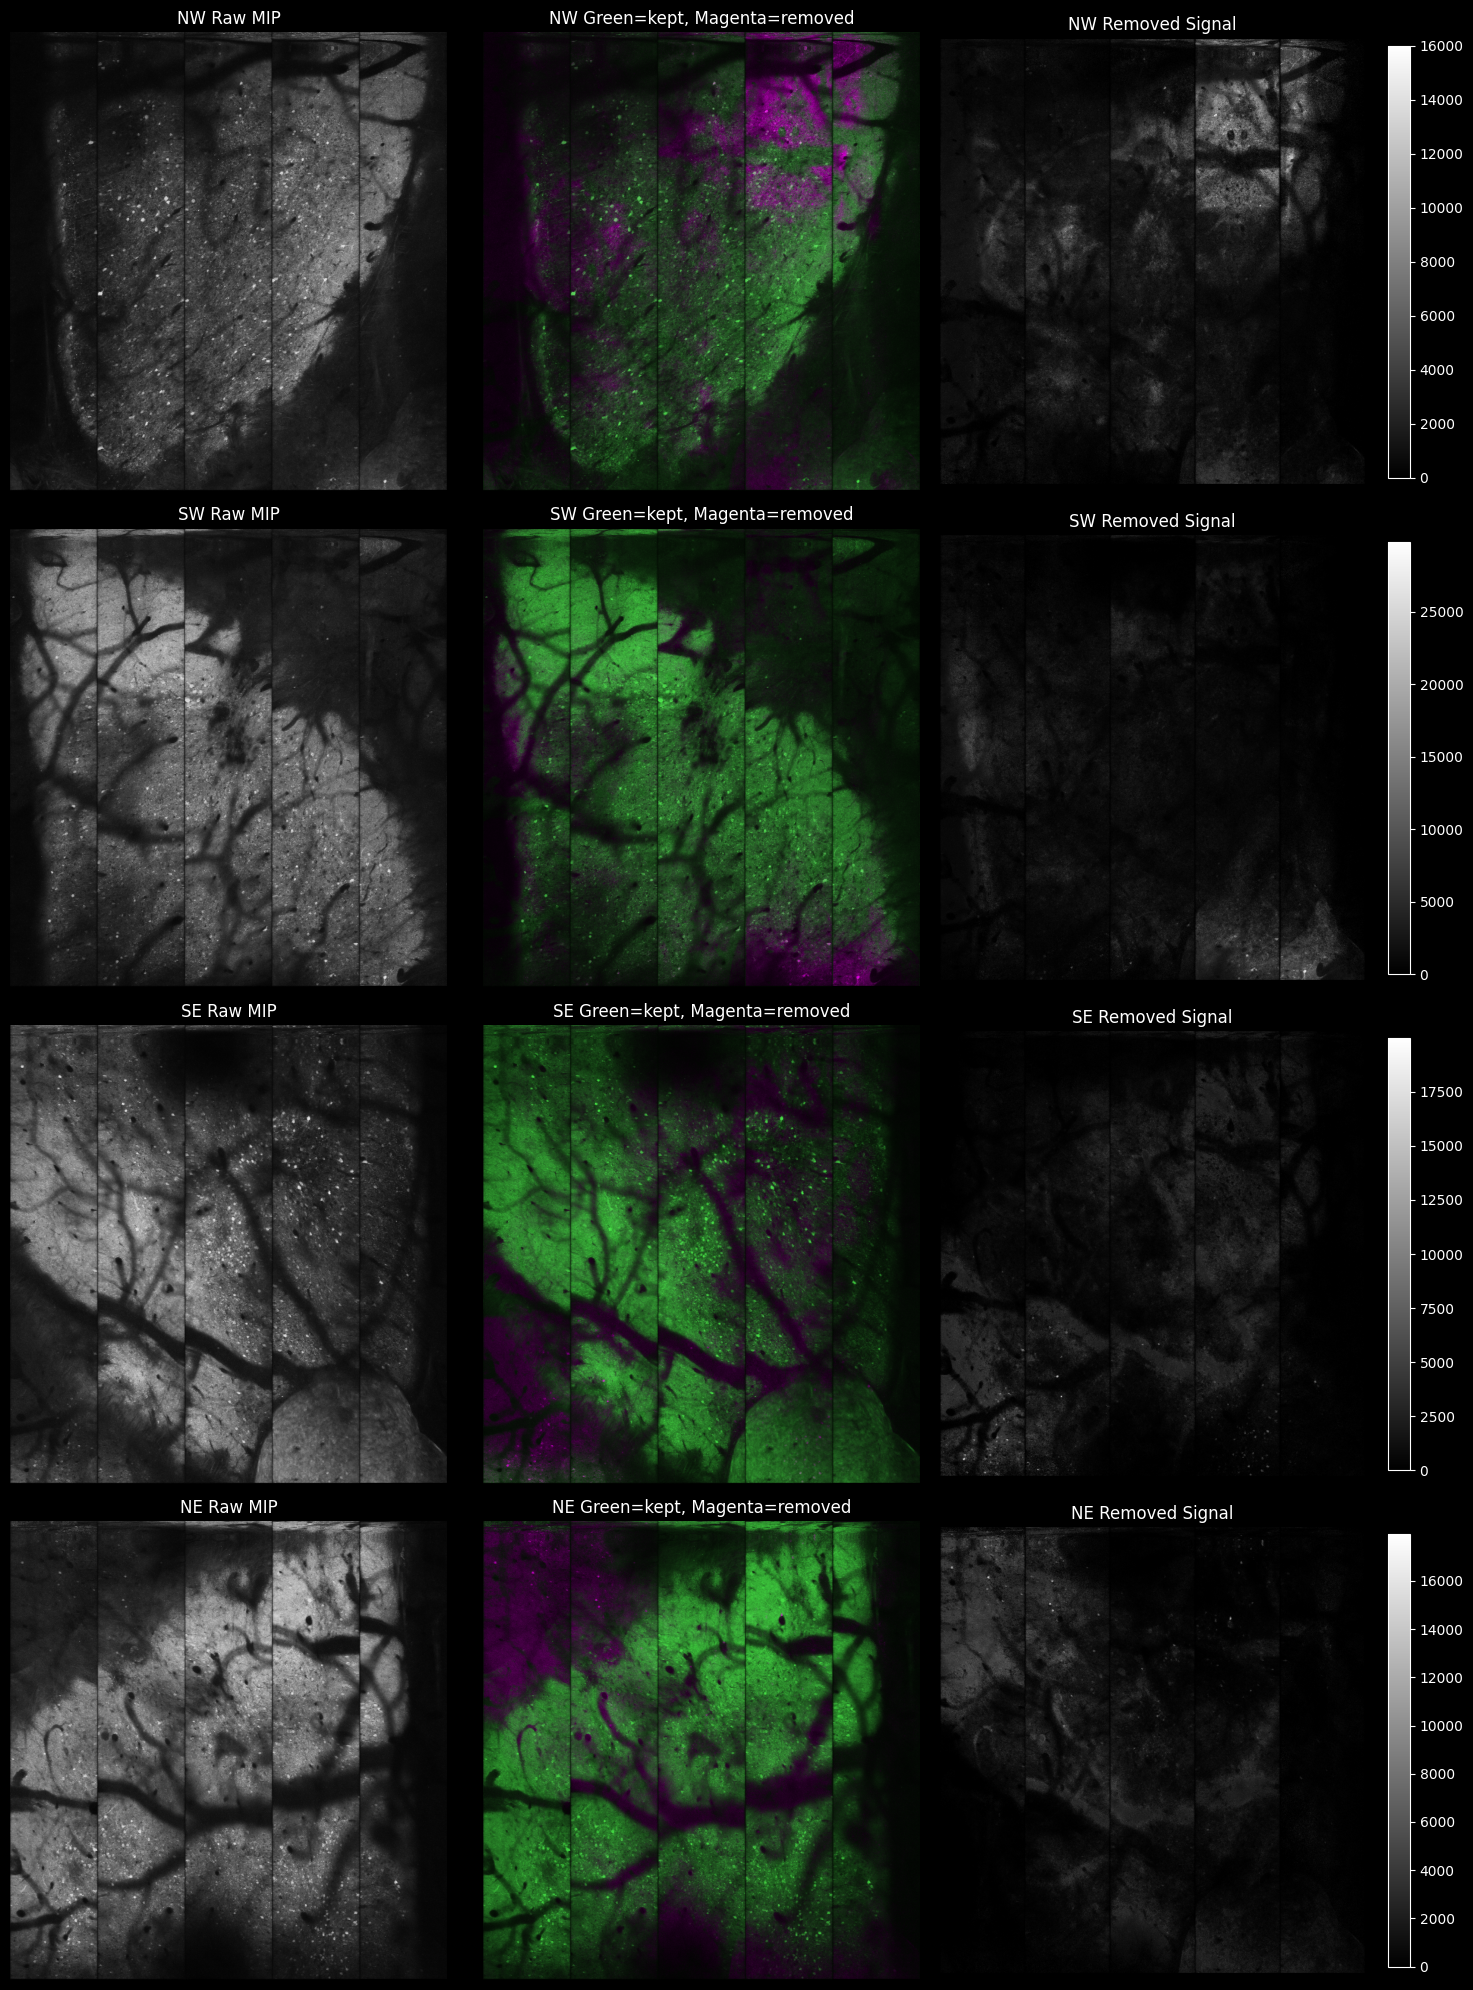

In [17]:
def normalize(img):
    """0-1 normalize for display."""
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-12)

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for i, label in enumerate(beam_labels):
    raw_mip = R[i].max(axis=0)
    demix_mip = S_est[i].max(axis=0)
    removed = np.clip(raw_mip - demix_mip, 0, None)

    # normalize for RGB
    raw_n = normalize(raw_mip)
    demix_n = normalize(demix_mip)
    removed_n = normalize(removed)

    # RGB: green=kept, magenta=removed
    rgb = np.stack([
        demix_n * 0.3 + removed_n,      # R: removed (magenta)
        demix_n,                          # G: kept signal
        demix_n * 0.3 + removed_n,      # B: removed (magenta)
    ], axis=-1)
    rgb = np.clip(rgb, 0, 1)

    # column 0: raw
    axes[i, 0].imshow(raw_mip, cmap="gray")
    axes[i, 0].set_title(f"{label} Raw MIP")
    axes[i, 0].axis("off")

    # column 1: RGB overlay
    axes[i, 1].imshow(rgb)
    axes[i, 1].set_title(f"{label} Green=kept, Magenta=removed")
    axes[i, 1].axis("off")

    # column 2: removed signal only (hot colormap)
    im = axes[i, 2].imshow(removed, cmap="gray")
    axes[i, 2].set_title(f"{label} Removed Signal")
    axes[i, 2].axis("off")
    plt.colorbar(im, ax=axes[i, 2], fraction=0.046)

plt.tight_layout()
plt.show()

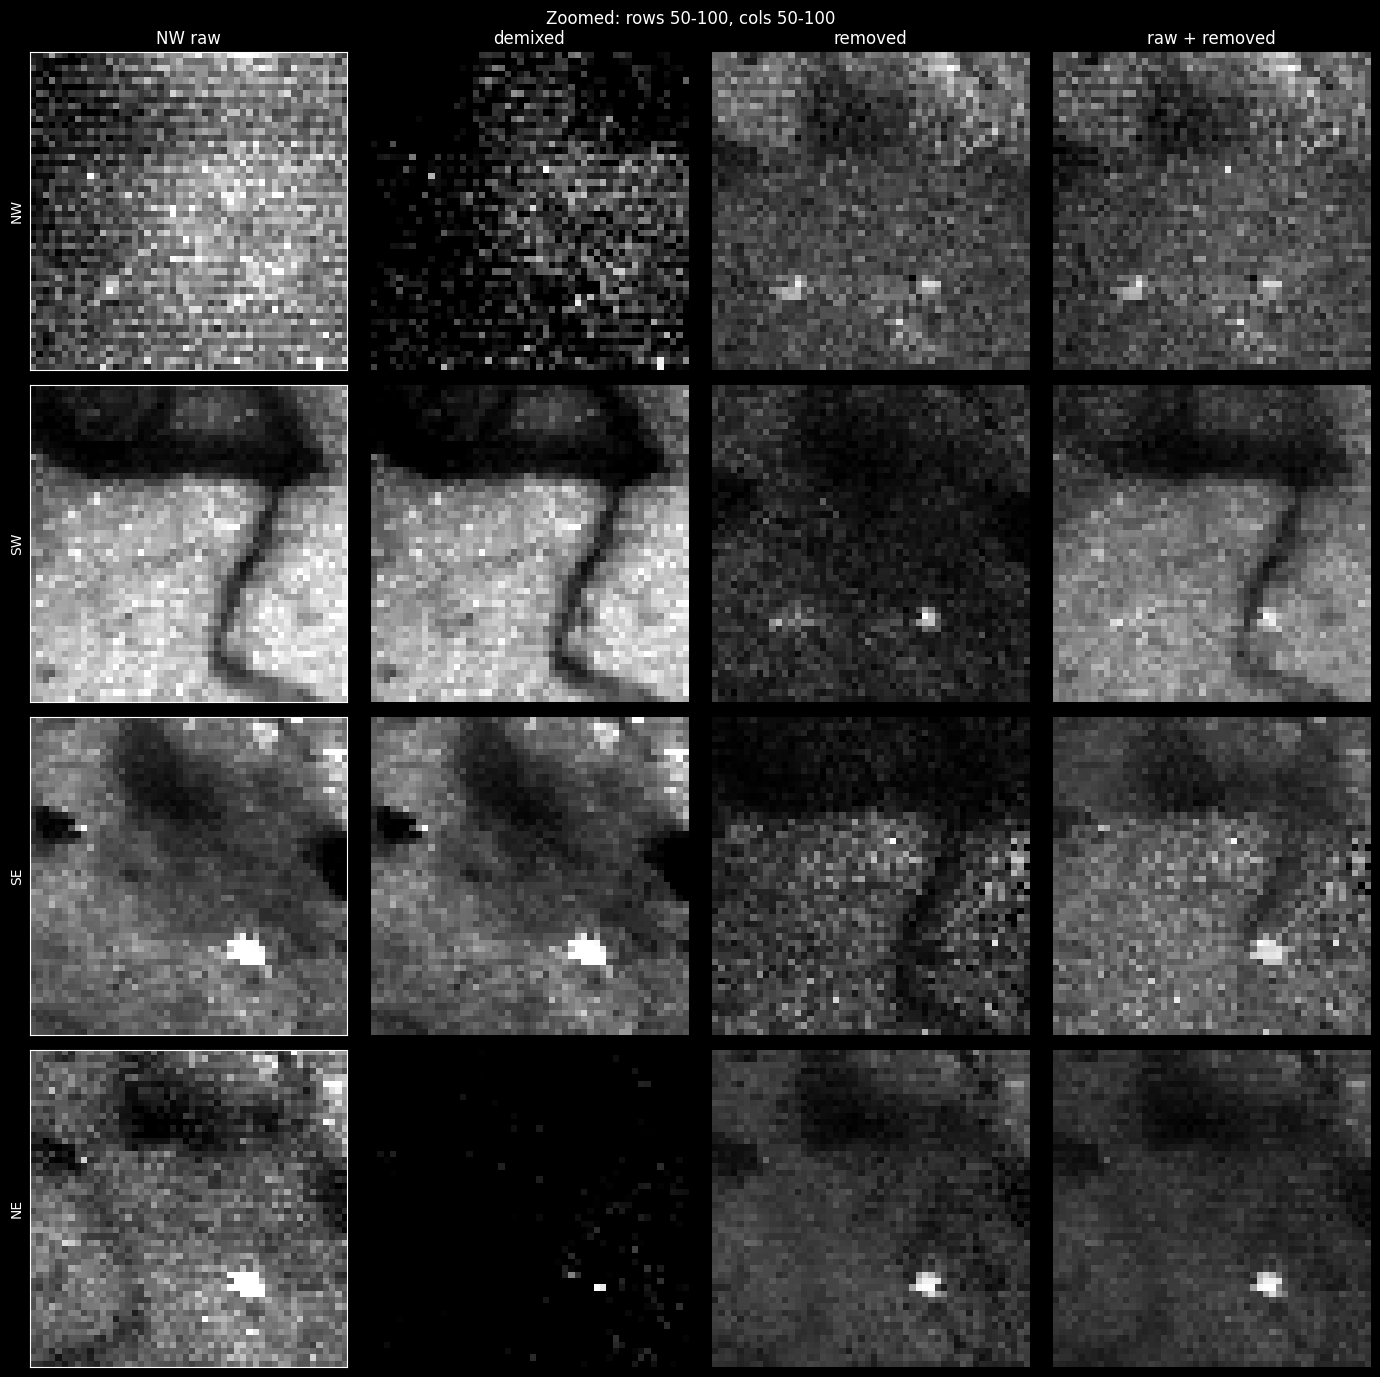

In [28]:
# adjust crop region as needed
# crop = (slice(250, 300), slice(250, 300))  # y, x
crop = (slice(50, 100), slice(50, 100))  # y, x

fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, label in enumerate(beam_labels):
    raw_crop = R[i].max(axis=0)[crop]
    demix_crop = S_est[i].max(axis=0)[crop]
    removed_crop = np.clip(raw_crop - demix_crop, 0, None)

    # normalize for display
    vmin, vmax = np.percentile(raw_crop, [1, 99])

    axes[i, 0].imshow(raw_crop, cmap="gray", vmin=vmin, vmax=vmax)
    axes[i, 0].set_title(f"{label} raw" if i == 0 else "")
    axes[i, 0].set_ylabel(label)
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].imshow(demix_crop, cmap="gray", vmin=vmin, vmax=vmax)
    axes[i, 1].set_title("demixed" if i == 0 else "")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(removed_crop, cmap="gray")
    axes[i, 2].set_title("removed" if i == 0 else "")
    axes[i, 2].axis("off")

    # blink-style: alpha blend
    blend = 0.5 * normalize(raw_crop) + 0.5 * normalize(removed_crop)
    axes[i, 3].imshow(blend, cmap="gray")
    axes[i, 3].set_title("raw + removed" if i == 0 else "")
    axes[i, 3].axis("off")

plt.suptitle(f"Zoomed: rows {crop[0].start}-{crop[0].stop}, cols {crop[1].start}-{crop[1].stop}")
plt.tight_layout()
plt.show()

If cross-talk persists, check:

1. **Alignment** - calibration vs recording spatial match
2. **Contaminated source** - `R[src]` itself has cross-talk
3. **Confidence under-subtraction** - dim regions subtract less
4. **Wrong noise percentile** - try 10 or 30 instead of 20

In [ ]:
# try iterative demixing
S_iter = R.copy()
for iteration in range(3):
    S_iter = demix_recording(S_iter, M_init)
    print(f"Iteration {iteration + 1} complete")

Iteration 1 complete
Iteration 2 complete
Iteration 3 complete


In [ ]:
# save demixed as zarr (one file with all 4 beams)
output_path = r"D:\cj\2025-11-21\demixed.zarr"

# stack as (T, 4, Y, X) so planes dimension = beams
demixed_stack = np.moveaxis(S_est, 0, 1)  # (4, T, Y, X) -> (T, 4, Y, X)
print(f"Saving shape: {demixed_stack.shape}")

mbo.imwrite(demixed_stack, output_path, ext=".zarr", overwrite=True)
print(f"Saved to {output_path}")

Saving shape: (970, 4, 772, 735)
Saved to D:\cj\2025-11-21\demixed.zarr


Then view with:
```bash
uv run mbo D:\cj\2025-11-21\demixed.zarr
```

## Save Results

In [ ]:
# # uncomment to save
output_root = Path(r"D:\cj\2025-11-21\demixed")
output_root.mkdir(exist_ok=True)

for idx, label in enumerate(beam_labels):
    outpath = os.path.join(output_root, label)
    mbo.imwrite(
        lazy_array=mbo.imread(S_est[idx]),
        outpath=outpath,
        ext=".zarr",
        overwrite=True,
    )
    print(f"Saved {label} to {outpath}")

Saving plane01.zarr:   0%|          | 0/21 [00:00<?, ?it/s]

Saved NW to D:\cj\2025-11-21\demixed\NW


Saving plane01.zarr:   0%|          | 0/21 [00:00<?, ?it/s]

Saved SW to D:\cj\2025-11-21\demixed\SW


Saving plane01.zarr:   0%|          | 0/21 [00:00<?, ?it/s]

Saved SE to D:\cj\2025-11-21\demixed\SE


Saving plane01.zarr:   0%|          | 0/21 [00:00<?, ?it/s]

Saved NE to D:\cj\2025-11-21\demixed\NE
